In [ ]:
!pip install catboost

Размер: (210, 8)
Первые 5 строк:
    area  perimeter  compactness  length_kernel  width_kernel  \
0  15.26      14.84       0.8710          5.763         3.312   
1  14.88      14.57       0.8811          5.554         3.333   
2  14.29      14.09       0.9050          5.291         3.337   
3  13.84      13.94       0.8955          5.324         3.379   
4  16.14      14.99       0.9034          5.658         3.562   

   asymmetry_coeff  length_kernel_groove  class  
0            2.221                 5.220      1  
1            1.018                 4.956      1  
2            2.699                 4.825      1  
3            2.259                 4.805      1  
4            1.355                 5.175      1  

Распределение классов:
class
1    70
2    70
3    70
Name: count, dtype: int64
Обучающая выборка: (147, 7)
Тестовая выборка: (63, 7)
Обучение Decision Tree...
Обучение Random Forest...
Обучение AdaBoost...
Обучение XGBoost...
Обучение CatBoost...

 Сравнение моделей:
       

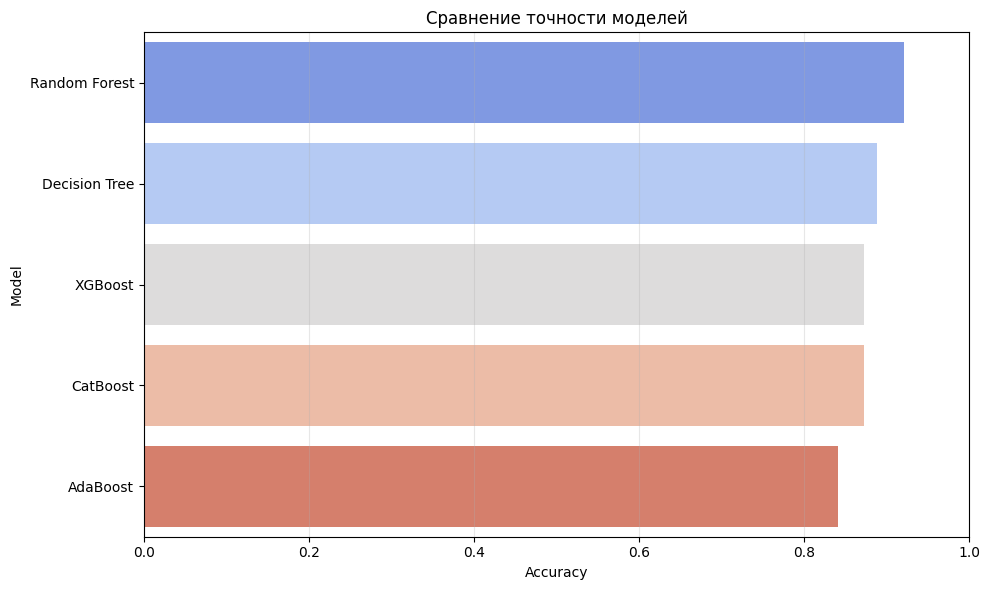


 Лучшая модель: Random Forest с точностью 0.9206

Детальный отчет для Random Forest:
              precision    recall  f1-score   support

        Kama       0.94      0.81      0.87        21
        Rosa       0.95      0.95      0.95        21
    Canadian       0.88      1.00      0.93        21

    accuracy                           0.92        63
   macro avg       0.92      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63



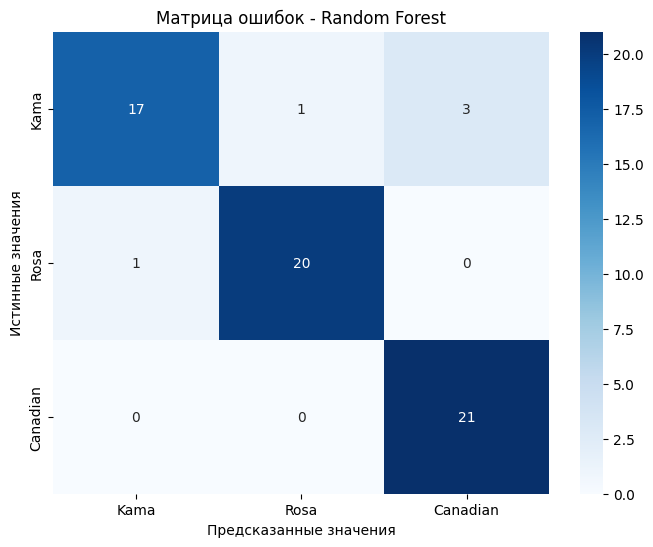


 Визуализация PCA...
Объясненная дисперсия компонент: [0.71874303 0.17108184]
Суммарная объясненная дисперсия: 0.8898


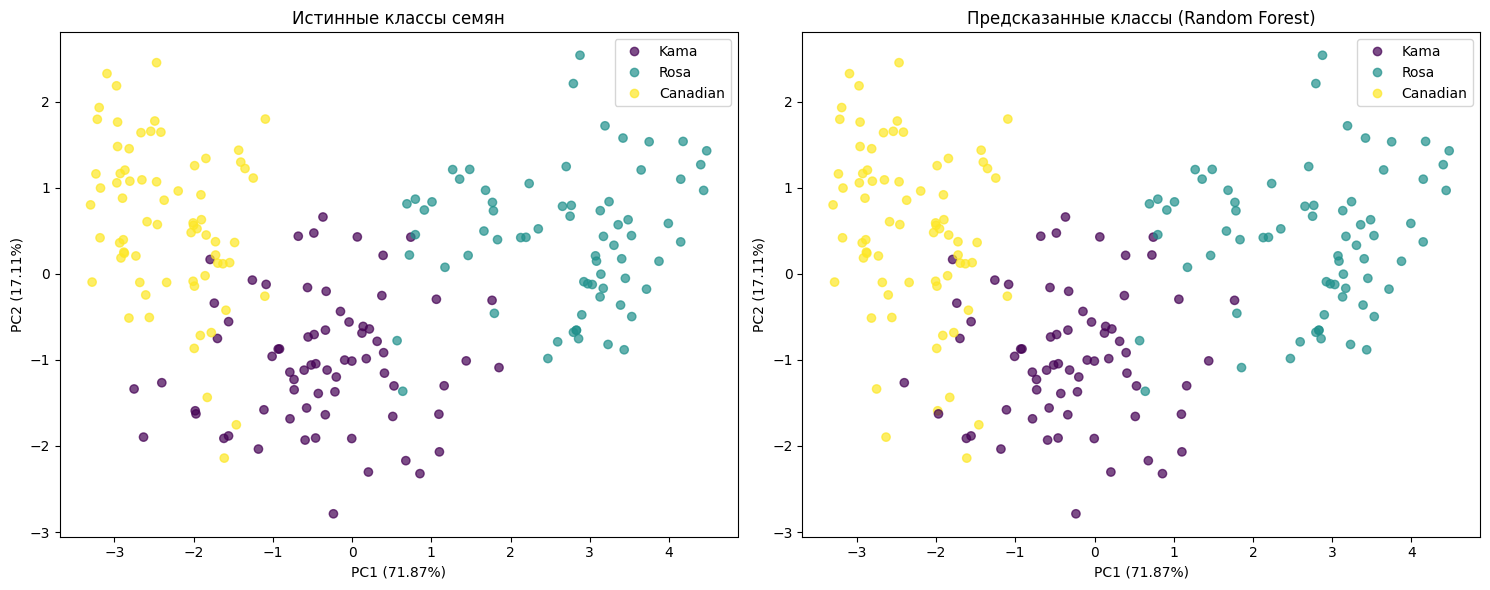

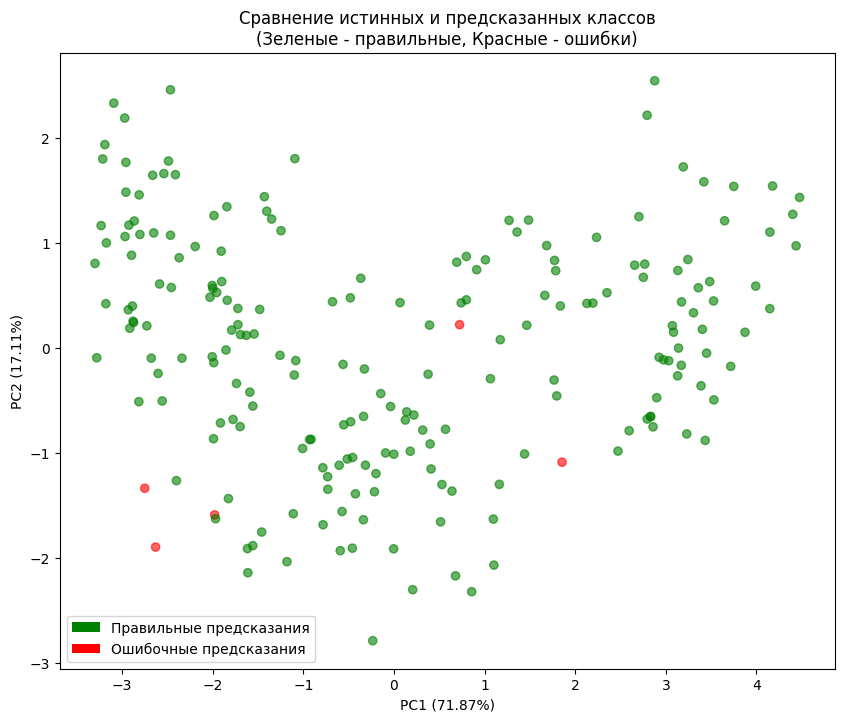

In [ ]:
!pip install catboost xgboost -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
columns = ['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
           'asymmetry_coeff', 'length_kernel_groove', 'class']

try:
    data = pd.read_csv(url, delim_whitespace=True, names=columns, na_values='?')
    data = data.dropna()
    print(f"Размер: {data.shape}")
except Exception as e:
    print(f"Ошибка загрузки: {e}")

    print("Пробуем альтернативный источник...")
    url_backup = "https://raw.githubusercontent.com/ttv-ms/static/main/seeds_dataset.txt"
    data = pd.read_csv(url_backup, delim_whitespace=True, names=columns, na_values='?')
    data = data.dropna()

print(f"Первые 5 строк:\n{data.head()}")
print(f"\nРаспределение классов:\n{data['class'].value_counts().sort_index()}")

X = data.drop('class', axis=1)
y = data['class']

y_fixed = y - 1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_fixed, test_size=0.3, random_state=42, stratify=y_fixed
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=False)
}

results = {}

for name, model in models.items():
    print(f"Обучение {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': y_pred
    }

print("\n Сравнение моделей:")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()]
}).sort_values('Accuracy', ascending=False)

print(comparison_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Accuracy', y='Model', palette='coolwarm')
plt.title('Сравнение точности моделей')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']
print(f"\n Лучшая модель: {best_model_name} с точностью {best_accuracy:.4f}")

print(f"\nДетальный отчет для {best_model_name}:")
y_pred_best = results[best_model_name]['predictions']
print(classification_report(y_test, y_pred_best,
                          target_names=['Kama', 'Rosa', 'Canadian']))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Kama', 'Rosa', 'Canadian'],
            yticklabels=['Kama', 'Rosa', 'Canadian'])
plt.title(f'Матрица ошибок - {best_model_name}')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.show()

print("\n Визуализация PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Объясненная дисперсия компонент: {pca.explained_variance_ratio_}")
print(f"Суммарная объясненная дисперсия: {sum(pca.explained_variance_ratio_):.4f}")

y_pred_all = best_model.predict(X_scaled)

viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'True_Class': y_fixed,
    'Predicted_Class': y_pred_all
})

def get_class_name(class_num):
    classes = {0: 'Kama', 1: 'Rosa', 2: 'Canadian'}
    return classes[class_num]

viz_df['True_Class_Name'] = viz_df['True_Class'].apply(get_class_name)
viz_df['Predicted_Class_Name'] = viz_df['Predicted_Class'].apply(get_class_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

scatter1 = ax1.scatter(viz_df['PC1'], viz_df['PC2'],
                      c=viz_df['True_Class'], cmap='viridis', alpha=0.7)
ax1.set_title('Истинные классы семян')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax1.legend(handles=scatter1.legend_elements()[0],
          labels=['Kama', 'Rosa', 'Canadian'])

scatter2 = ax2.scatter(viz_df['PC1'], viz_df['PC2'],
                      c=viz_df['Predicted_Class'], cmap='viridis', alpha=0.7)
ax2.set_title(f'Предсказанные классы ({best_model_name})')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax2.legend(handles=scatter2.legend_elements()[0],
          labels=['Kama', 'Rosa', 'Canadian'])

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
correct_predictions = (viz_df['True_Class'] == viz_df['Predicted_Class'])
colors = ['red' if not correct else 'green' for correct in correct_predictions]

plt.scatter(viz_df['PC1'], viz_df['PC2'], c=colors, alpha=0.6)
plt.title('Сравнение истинных и предсказанных классов\n(Зеленые - правильные, Красные - ошибки)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Правильные предсказания'),
    Patch(facecolor='red', label='Ошибочные предсказания')
]
plt.legend(handles=legend_elements)
plt.show()